# Regression Model
This is the regression model that is trained to predict accurate depth maps (e.g 128,128) from single input RGB images (e.g 512. 512, 3). A set of experiments takes place, in this notebook. In summary:

*   Define X (Input Images) and Y (GT-depth maps) data
*   Select Depth Regression Network Architecture
*   Train Model for a number of initial samples
*   Test on random sample/example




## Dataset
Define the path to the dataset for the input data and the ground truth depth maps. Load everything to the dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

input_data_path = '/content/drive/MyDrive/datasets/eg3d/images/' #@param
gt_data_path = '/content/drive/MyDrive/datasets/eg3d/latent/' #@param

Mounted at /content/drive


## Utilities

In [ ]:
# Function to convert a depth image to a mesh 
# Adapted from https://github.com/sfu-gruvi-3dv/deep_human
import PIL
import numpy as np
from tqdm import tqdm
import torch
def depthImage2mesh(img_path, save=False, output_path='/content/drive/MyDrive/eg3d/output/mesh.obj'):
  ''' Convert a depth image to mesh constituents 
    - img_path: string path to depth image (.png)
    return:
    - verts: torch.tensor (B, N, 3), where B for batch size and N for 
    number of vertices
    - faces: torch.tensor (B, F, 3), where B for batch size and F for
     number of faces --> indeces of vertices
    - colors: torch.tensor (B, N, 3), where B for batch size and N for
     number of vertices
  '''
  # Read image and depth values
  img = np.array(PIL.Image.open(img_path))
  #print(img.shape, img.dtype, img[0])
  
  
  # Normalize to depth values in [-1,1] 
  maxx = np.amax(img)
  minx = np.amin(img)
  x = 2 * ((img - minx) / (maxx - minx) ) - 1
  img =  np.array(x, dtype=np.float32)
  depth = -img.copy()
  mask = img.copy()
  mask[mask < 0] = 1

  ## Convert to vertices with depth
  h = depth.shape[0]
  w = depth.shape[1]
  depth = depth.reshape(h,w,1)
  faces = []  # N x 3  number of triangles
  verts = [] # V x 3 number of vertices
  v_strings = [] # strings with vertices for obj
  f_strings = [] # strings with faces for obj
  for i in range(h):
      for j in range(w):
          verts.append( [float(2.0*i/h) , float(2.0*j/w), float(depth[i,j,0])] )
          v_strings.append('v '+str(float(2.0*i/h))+' '+str(float(2.0*j/w))+' '+str(float(depth[i,j,0]))+'\n')

  threshold = 1.5 # adapted for better mesh quality --> the higher the more robust the result
  # no mesh face gaps
  
  
  for i in tqdm(range(h-1)):
      for j in range(w-1):
          if i < 2 or j < 2:
              continue
          localpatch= np.copy(depth[i-1:i+2,j-1:j+2])
          dy_d = localpatch[0, :] - localpatch[1, :]
          dx_l = localpatch[:, 0] - localpatch[:, 1]
          dx_r = localpatch[0 ,:] - localpatch[-1, :]
          dy_u = localpatch[:, 0] - localpatch[:, -1]

          dy_u = np.abs(dy_u)
          dx_l = np.abs(dx_l)
          dy_d = np.abs(dy_d)
          dx_r = np.abs(dx_r)
          if np.max(dy_u)<threshold and np.max(dx_l) < threshold and np.max(dy_d) < threshold and np.max(dx_r) < threshold and mask[i,j]:
              faces.append([int(j+i*w+1), int(j+i*w+1+1), int((i + 1)*w+j+1)])
              faces.append([int((i+1)*w+j+1+1), int((i+1)*w+j+1), int(i * w + j + 1 + 1)])
              # strings for .obj format
              f_strings.append('f '+str(int(j+i*w+1))+' '+str(int(j+i*w+1+1))+' '+str(int((i + 1)*w+j+1))+'\n')
              f_strings.append('f '+str(int((i+1)*w+j+1+1))+' '+str(int((i+1)*w+j+1))+' '+str(int(i * w + j + 1 + 1)) + '\n')

  lim = len(verts) # cannot have valid indeces above this
  safe_faces = []
  for i, fac in enumerate(faces):
    problem = False
    for inds in fac:
      if inds >=lim:
        problem = True
        continue
      else:
        pass
    if not problem:
      safe_faces.append(fac)


  # Save
  f = open(output_path, "w")
  if save:
    for index, v in enumerate(v_strings):
      f.write(v)

    for index, fac in enumerate(f_strings):
      f.write(fac)
  f.close()
    

  verts = torch.from_numpy(np.array(verts)).to(torch.float32).unsqueeze(0)
  faces = torch.from_numpy(np.array(safe_faces)).unsqueeze(0)
  verts_rgb = 0.5* torch.ones_like(verts) # (1, V, 3) # colors



  return verts, faces, verts_rgb

In [ ]:
depth_path = '/content/drive/MyDrive/datasets/eg3d/depth/seed0001.png'
verts, faces, colors = depthImage2mesh(depth_path, save=False)
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Transforms

# Transform latent code
def transform_latent(code):
  ''' This method transforms a 3D latent code (e.g shape (1, 14, 512) ) to a vector (e.g size = 512*14 ) and vice verca'''
  if len(code.shape) < 2:
    code = code.reshape((1, 512, 14))
  if len(code.shape) > 2:
    code = code.reshape(-1)

  return code

## ViT
The Vision Transformer - [ViT](https://github.com/lukemelas/PyTorch-Pretrained-ViT) developed initially by Googles used to predict the EG3D latent code . The model ViT-B_16_imagenet1k is used, which is the a base vision transformer (12 transformer layers per transformer) with local patches of (16x16) already pretrained on Imagenet with 1000 images.

In [ ]:
!pip install pytorch_pretrained_vit
!pip install vit-pytorch

In [ ]:
# Old
from pytorch_pretrained_vit import ViT
model = ViT('B_16_imagenet1k', pretrained=False, image_size=384) # Assumme image size of (512, 512, 3)
#config = dict(hidden_size=512, num_heads=8, num_layers=6)
#model = ViT.from_config(config)
model.fc = torch.nn.Linear(in_features=768, out_features=512*14)
model = model.to(device) # input to model (1, 3, 512, 512)

In [ ]:
# New
import torch
from vit_pytorch import ViT

model = ViT(
    image_size = 384,
    patch_size = 16,
    num_classes = 7168,
    dim = 1024, # set to 3000
    depth = 12, # set to 6
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

img = torch.zeros(1,3 , 384, 384)
preds = model(img) # (1, 7168)

## Train Model
Create different sets of experiments and train different models with different data and split sets. The experiments are saved in different folders under **./experiments**. Each seperate experiment folder containts a **'.pt'** pytorch checkpoint model weights, a **'train.npy'** and **'test.npy'** numpy files that hold the paths of the training and testing data ( input and grounf truth data paths). The **'train.npy'** file holds a dictionary of arrays that can be accessed using the key **'trainX'** and **'trainY'**. Respectively, to get the paths of the validation data, load the **'val.npy'** and query the 2 arrays using **'valX** and **'valY'** keys.

### Steps
1. Model Architecture
2. Preprocessing
3. Postprocessing
4. Validation/Training dataset split
5. Model Training and save
6. Visualize/Report training in Tensorboard

In [ ]:
from torchvision.transforms import Compose
import torch.optim as optim
import torch.nn as nn
import torch
import os
import cv2
#import utils
import numpy as np
import PIL
from torchvision import transforms

l1_loss = nn.L1Loss(reduction='mean') # l1-loss
mse = nn.MSELoss(reduction='mean') # mse  (mean squared error) loss
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.train() # set in train mode
model.to(device)



# Load image
transform = transforms.Compose([
    transforms.Resize((384, 384)), 
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])


lr = 0.0001
momentum = 0.9
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                            patience=10, verbose=True)

pretrained_modelpath = "/content/drive/MyDrive/eg3d/experiments/VIT_latent_train48000_samples_depth12/b5_e20_weights_ckp4_it3000.pt"
optimizer_path = "/content/drive/MyDrive/eg3d/experiments/VIT_latent_train48000_samples_depth12/b5_e20_optimizer_ckp4_it3000.pt"
model.load_state_dict(torch.load(pretrained_modelpath)) # load the final training weights
optimizer.load_state_dict(torch.load(optimizer_path)) # load the optimizer state

In [ ]:
### Function to perform validation
import time
def validate(model, X, Y, criterion):
  '''
  X: list that contains batches of input data [N , B], for N - numper of batches
  and B the batch size
  Y: GT data stored as batches of gt data [N , B]
  '''
  flat_valX = np.array(X).reshape(-1)
  flat_valY = np.array(Y).reshape(-1)
  assert len(flat_valX) == len(flat_valY)
  inputs = []
  gts = []
  tot_val = 0
  #start = time.time()
  with torch.no_grad():
    for i in range(0, len(flat_valX)):
        gt_np = np.load(flat_valY[i]) # bring to appropriate shape
        gt_vec = gt_np.flatten()
        #gt_np = transform_latent(gt_np) # comment for UNET-modified model
        img = PIL.Image.open(filepath)
        img_input = transform(img).cpu().detach().numpy()
        input = torch.from_numpy(img_input).to(device).unsqueeze(0)
        gt = torch.tensor(gt_vec, requires_grad=True).to(device).unsqueeze(0)
        gts.append(gt)
        inputs.append(input)
        prediction = model(input)
        val_loss = criterion(prediction, gt)
        tot_val = tot_val + val_loss
  return tot_val

In [ ]:
### Create list with GT and input data paths
batch_size =  5#@param
experiment_name = "VIT_latent_train48000_samples_depth12" #@param {type: "string"}
experiment_root = '/content/drive/MyDrive/eg3d/experiments' #@param {type: "string"}
experiment_path = os.path.join(experiment_root, experiment_name)
save_train = os.path.join(experiment_path, 'train.npy')
save_val = os.path.join(experiment_path, 'val.npy')
log_file = os.path.join(experiment_path, 'info.log')
os.makedirs(experiment_path, exist_ok=True)
img_data = []
gt_data = []
for img in sorted(os.listdir(input_data_path)):
    filepath = os.path.join(input_data_path, img)
    gt_path = os.path.join(gt_data_path, img).replace('png', 'npy')
    img_data.append(filepath)
    gt_data.append(gt_path)


img_data = [img_data[i:i + batch_size] for i in range(0, len(img_data), batch_size )] 
gt_data = [gt_data[i:i+batch_size] for i in range(0, len(gt_data), batch_size)] 


### Dataset split (Train/Val)
num_samples_train =  47500 #@param
num_samples_val =    200 #@param
limit_train = int(num_samples_train / batch_size) # number of training batches
limit_val = int(num_samples_val / batch_size) # number of validation batches
valX = img_data[0:limit_val] # first n batches
valY = gt_data[0:limit_val]
trainX = img_data[limit_val:limit_train+limit_val]
trainY = gt_data[limit_val:limit_train+limit_val]


np.save(os.path.join(experiment_path,'train.npy'),
        {'trainX': trainX,  'trainY': trainY})
np.save(os.path.join(experiment_path, 'val.npy'),
        {'valX': valX,  'valY': valY})

In [ ]:
from torchvision.transforms import Compose
import torch.optim as optim
import torch.nn as nn
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
from torchvision.transforms import Compose
import torch.optim as optim
import torch.nn as nn
import torch
import os
import cv2
import numpy as np
import PIL
from torchvision import transforms### Training Skeleton
from tqdm import tqdm
import logging as lg
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torch
import random
n_epochs =      20#@param
f = open(log_file.replace('log', 'txt'), 'w')
comment = '_e{}b{}lr{}t_samples{}v_samples{}'.format(n_epochs, batch_size, lr,
                                                     num_samples_train, num_samples_val)
f.write(comment) 
writer = SummaryWriter() # Tensorboard writer


for epoch in range(5, n_epochs+1):
    total_loss = 0.0
    random.shuffle(trainX)
    # Save model weights every 100 epochs
    if (epoch % 1) == 0 :
      weights_savepath = os.path.join(experiment_path, 
      'b{}_e{}_weights_ckp_{}.pt'.format(batch_size, n_epochs, epoch))
      torch.save(model.state_dict(), weights_savepath)
      torch.save(optimizer.state_dict(), weights_savepath.replace("weights", "optimizer"))
    for i, batch in enumerate(tqdm(trainX, position=0, leave=True)):
      inputs = [] # batch inputs
      gts = [] # batch labels/gt data
      if (i % 3000) == 0: # add checkpoints for many iterations (to avoid colab timeouts)
        weights_savepath = os.path.join(experiment_path, 
        'b{}_e{}_weights_ckp{}_it{}.pt'.format(batch_size, n_epochs, epoch, i))
        torch.save(model.state_dict(), weights_savepath)
        torch.save(optimizer.state_dict(), weights_savepath.replace("weights", "optimizer"))

      for filepath in batch:
        gt_path = filepath.replace('images', 'latent').replace('png', 'npy')
        gt_np = np.load(gt_path)
        gt_vec = gt_np.flatten()
        img = PIL.Image.open(filepath)
        img_input = transform(img).cpu().detach().numpy()
        #plt.imshow(img_input.transpose())
        input = torch.from_numpy(img_input).to(device).unsqueeze(0)
        gt = torch.tensor(gt_vec).to(device).unsqueeze(0)
        gts.append(gt)
        inputs.append(input)

      # Convert list to batch tensor
      gts = torch.cat(gts)
      inputs = torch.cat(inputs)

      
      # Per batch loss and update
      predictions = model(inputs)
      #print(predictions.shape, gts.shape)
      pred_np = predictions.detach().cpu().numpy()

      
      #loss = mse(gts, predictions) # total loss per batch
      loss = l1_loss(gts, predictions)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_loss += float(loss) # total average batch loss
    

    
    total_val_loss = validate(model, X=valX, Y=valY, criterion=l1_loss)
    val_loss = total_val_loss / num_samples_val  # average val loss
    training_loss = total_loss / limit_train # average training loss
    log = ' '.join(["e", str(epoch),"- Average L1 loss: %f , Val. loss: %f" %(training_loss,val_loss)])
    # logger.info(log)
    writer.add_scalars("Loss", {'train': training_loss, 'val':val_loss},
                      epoch)
    writer.add_scalar("Loss/train", training_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    print(log)
    f.write(log + '\n')
    f.flush()
    writer.flush()
    lr_scheduler.step(total_loss)


f.close() # stop writing in file
#writer.add_mesh(tag='mesh', vertices=verts, faces=faces, colors=colors)
writer.close() # stop Tensorboard writing

100%|██████████| 9500/9500 [10:56:49<00:00,  4.15s/it]


e 11 - Average L1 loss: 0.154960 , Val. loss: 0.231101


100%|██████████| 9500/9500 [3:23:41<00:00,  1.29s/it]


e 12 - Average L1 loss: 0.153062 , Val. loss: 0.224579


 97%|█████████▋| 9225/9500 [3:12:41<14:55,  3.26s/it]

In [ ]:
np.save('/content/new.npy', pred_np)

In [ ]:
# Save model weights
torch.save(model.state_dict(), weights_savepath)

In [ ]:
# Run Tensorboard locally
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
# Upload Tensorboard  analytics to .dev
!tensorboard dev upload --logdir runs \
--name {experiment_name} \
--description "Simple check up test"

## Test Model
Input an RGB single-view image of a human face and predict the EG3D latent code (style vector).All latent code predictions can be reproduced/synthesized (via EG3D) to the respective images using [this notebook](https://colab.research.google.com/drive/1rILRjSyH_TPyk4Jhf6xHneU7DxZvskZv?usp=sharing)

In [ ]:
#@markdown Create and save list of image paths $ \to\ $ '/content/val.npy'
import os
paths = []
path = '/content/drive/MyDrive/datasets/FFHQ/00000/'
for img_path in os.listdir(path):
  if ('.jpg' in img_path) or ('.png' in img_path):
    fullpath = os.path.join(path, img_path)
    paths.append(fullpath)

  if len(paths) > 2:
    break 

np.save('/content/val.npy', {'valX': paths})
#np.save('/content/val.npy', paths)

In [ ]:
from torchvision.transforms import Compose
import torch.optim as optim
import torch.nn as nn
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
from torchvision.transforms import Compose
import torch.optim as optim
import torch.nn as nn
import torch
import os
import cv2
import numpy as np
import PIL
from torchvision import transforms

model_path =  "/content/drive/MyDrive/eg3d/experiments/VIT_latent_overfit10samples/b1_e10_weights_ckp_10.pt" #@param {type: "string"}
img_path = '/content/drive/MyDrive/datasets/eg3d/images/seed48495.png' #@param {type: "string"}
#@markdown or give a path to a list of images
img_list_path = "/content/val.npy" #@param {type: "string"}
save = True #@param {type:"boolean"}
output_root = '/content/' #@param {type: "string"}


# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: %s" % device)

# Load image
# NOTE: Assumes an image `img.jpg` exists in the current directory
transform = transforms.Compose([
    transforms.Resize((384, 384)), 
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

model.load_state_dict(torch.load(model_path))
model.eval()
model.to(device)

try:
  img_list = np.load(img_list_path, allow_pickle=True).item()['valX']
except:
  try:
    img_list = np.load(img_list_path, allow_pickle=True)
  except:
    print('Img path list is not used or wrong path/format')
    img_list = [[img_path], ]


# get input
with torch.no_grad():
  for img_path in img_list:
    img = PIL.Image.open(filepath)
    img_input = transform(img).cpu().detach().numpy()
    input = torch.from_numpy(img_input).to(device).unsqueeze(0)
    prediction = model(input)
    prediction = prediction.squeeze().detach().cpu().numpy().transpose() # convert to (1, 14, 512)
    img_name = 'out'
    example = img_path.split('/')[-1].split('.')[0] # name of sample
    os.makedirs(os.path.join(output_root, example), exist_ok=True)
    filename = os.path.join(
    os.path.join(output_root,example), os.path.splitext(os.path.basename(img_name))[0])
    output_path = filename + '.png'
    npy_savepath = filename + '.npy'
    #save input image
    if save:
      PIL.Image.open(img_path).save(output_path.replace('out', 'input'))
      # save latent code
      prediction = np.expand_dims(prediction, axis=0)
      np.save(npy_savepath, prediction)
    

print("finished")

/content/MiDaS
device: cuda
finished


## Model Evaluation
To evaluate the model on unseen data, the **mean l1-loss** is used as an evaluation metric. For proper evaluation, paths to both the **input image** and corresponding **gt latent code**, are required. All latent code predictions can be reproduced/synthesized (via EG3D) to the respective images using [this notebook](https://colab.research.google.com/drive/1rILRjSyH_TPyk4Jhf6xHneU7DxZvskZv?usp=sharing)

In [ ]:
#@markdown Save your img files and gt latent code $ \to\ $ '/content/val.npy' and '/content/val_gt.npy'
import os
paths = [] # image paths
gt_paths = []
#path = '/content/drive/MyDrive/datasets/FFHQ/00000/'
path = '/content/drive/MyDrive/datasets/eg3d/images'
#path = '/content/drive/MyDrive/datasets/prosopo_new/input/'

'''
for i, img_path in enumerate(sorted(os.listdir(path), reverse=False)):
  if i >=48000:
    fullpath = os.path.join(path, img_path)
    paths.append(fullpath)
    #gt_paths.append(fullpath.replace('images', 'latent').replace('png', 'npy'))
    gt_paths.append(fullpath.replace('input', 'latent').replace('png', 'npy'))

  if len(paths) > 1600:
    break
    
'''
paths = []
gt_paths = []
for i in range(47800, 49400):
  fullpath = os.path.join(path, f'seed{i:04d}.png')
  paths.append(fullpath)
  gt_paths.append(fullpath.replace('images', 'latent').replace('png', 'npy'))


np.save('/content/val.npy', paths)
np.save('/content/val_gt.npy', gt_paths)
print(paths)
print("Validation set ---> {} samples".format(len(paths)))

['/content/drive/MyDrive/datasets/eg3d/images/seed47800.png', '/content/drive/MyDrive/datasets/eg3d/images/seed47801.png', '/content/drive/MyDrive/datasets/eg3d/images/seed47802.png', '/content/drive/MyDrive/datasets/eg3d/images/seed47803.png', '/content/drive/MyDrive/datasets/eg3d/images/seed47804.png', '/content/drive/MyDrive/datasets/eg3d/images/seed47805.png', '/content/drive/MyDrive/datasets/eg3d/images/seed47806.png', '/content/drive/MyDrive/datasets/eg3d/images/seed47807.png', '/content/drive/MyDrive/datasets/eg3d/images/seed47808.png', '/content/drive/MyDrive/datasets/eg3d/images/seed47809.png', '/content/drive/MyDrive/datasets/eg3d/images/seed47810.png', '/content/drive/MyDrive/datasets/eg3d/images/seed47811.png', '/content/drive/MyDrive/datasets/eg3d/images/seed47812.png', '/content/drive/MyDrive/datasets/eg3d/images/seed47813.png', '/content/drive/MyDrive/datasets/eg3d/images/seed47814.png', '/content/drive/MyDrive/datasets/eg3d/images/seed47815.png', '/content/drive/MyDrive

In [ ]:
### Evaluate model
from torchvision.transforms import Compose
import torch.optim as optim
import torch.nn as nn
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
from torchvision.transforms import Compose
import torch.optim as optim
import torch.nn as nn
import torch
import os
import cv2
import numpy as np
import PIL
from torchvision import transforms



# Load image
transform = transforms.Compose([
    transforms.Resize((384, 384)), 
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])


model_path =  "/content/drive/MyDrive/eg3d/experiments/VIT_latent_train48000_samples_depth12/b5_e20_weights_ckp_2.pt"#@param {type: "string"}
img_path = '/content/drive/MyDrive/datasets/prosopo/input/mein/monalisa.jpg' #@param {type: "string"}
gt_path = '/content/drive/MyDrive/datasets/prosopo/input/mein/monalisa_gt.jpg' #@param {type: "string"}
#@markdown or give a path to a list of images
img_list_path = "/content/val.npy" #@param {type: "string"}
gt_list_path = "/content/val_gt.npy" #@param {type: "string"}
#output_root = '/content/drive/MyDrive/eg3d/output/' 
output_root = '/'.join(model_path.split('/')[:-1])
#@markdown Save results?
save = False #@param {type:"boolean"}




# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: %s" % device)

# load network
try:
  model.load_state_dict(torch.load(model_path, map_location=device)) #model architeture is selected above
  model.eval()
  model.to(device)
except:
  raise Exception('Model architecture and model weights did not match! Are you using the corrrect model?')


try:
  image_paths = np.load(img_list_path, allow_pickle=True)
  gt_paths = np.load(gt_list_path, allow_pickle=True)
except:
    try:
      image_paths = np.load(img_list_path, allow_pickle=True).item()['valX']
      gt_paths = np.load(img_list_path, allow_pickle=True).item()['valY']
    except:
      image_paths = [img_path, ]
      gt_paths = [gt_path, ]


l1_loss = nn.L1Loss(reduction='mean') # l1-loss
testX = np.array(image_paths).reshape( len(image_paths), 1)
testY = np.array(gt_paths).reshape( len(gt_paths), 1)
try:
  tot_loss = validate(model=model, X=testX, Y=testY, criterion=l1_loss)
  print("Mean L1-loss is:", tot_loss.item()/len(testX))
except:
  print("Not enough GPU memory to vaidate on large batch size")





# counter for perfect results
perfect = 0 
tot_loss = 0

with torch.no_grad():
  for i in tqdm(range(len(image_paths))):
    # get current gt and img path
    img_path = image_paths[i]
    gt_path = gt_paths[i]
    img = PIL.Image.open(img_path)
    img_input = transform(img).cpu().detach().numpy()
    input = torch.from_numpy(img_input).to(device).unsqueeze(0)
    prediction = model(input)
    prediction_np = prediction.squeeze().cpu().numpy().transpose() # convert to (1, 14, 512)
    
    # gt
    gt_np = np.load(gt_path, allow_pickle=True)
    gt_vec = gt_np.flatten()
    gt_np = transform_latent(gt_np) # comment for UNET-modified model
    gt = torch.tensor(gt_vec).to(device).unsqueeze(0)
    img_name = 'out'
    #filename = os.path.join(
    #os.path.join(output_root,example), os.path.splitext(os.path.basename(img_name))[0])
    #output_path = filename + '.png'
    sample_loss = l1_loss(prediction, gt)
    if sample_loss < 0.20:
      perfect = perfect + 1
      #print(f'Sample loss ({i})', sample_loss.item())
    tot_loss = tot_loss + sample_loss

    if save:
      os.makedirs(os.path.join(output_root, example), exist_ok=True)
      #save input image
      PIL.Image.open(img_path).save(output_path.replace('out', 'input'))
      # save gt depth map
      PIL.Image.open(gt_path).save(output_path.replace('out', 'gt'))


print('\n', "Perfects:", perfect, "Out of:", len(image_paths))
print('\n', "Total loss:  {}".format(tot_loss/i))


/content/MiDaS
device: cuda
Not enough GPU memory to vaidate on large batch size


100%|██████████| 1600/1600 [20:36<00:00,  1.29it/s]


 Perfects: 0 Out of: 1600

 Total loss:  0.28304624557495117


## Dump

In [ ]:
### Check Model parameters
p =  []
for name, param in model.named_parameters():
  if name == 'pretrained.model.patch_embed.proj.weight':
    a_param = param.detach().cpu().numpy()  

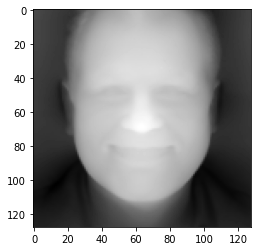

In [ ]:
import torch
input = torch.load('/content/input.pt')
out = torch.load('/content/gt.pt')
from matplotlib import pyplot as plt
inp = np.moveaxis(input.detach().cpu().numpy(), 0 , -1)
norm_inp = (inp+1)/2 # normalize from [-1, 1] to [0, 1]
plt.imsave("/content/input.png", norm_inp)
plt.imshow(out.detach().cpu().numpy(), cmap='gray')

In [ ]:
from midas.transforms import Resize, NormalizeImage, PrepareForNet
depth_path = '/content/drive/MyDrive/datasets/eg3d/depth128x128/seed0001.png'
gt_np = utils.read_image(depth_path)
r = Resize(width=512, height=512, resize_target=False)

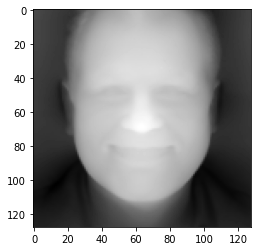

In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure()
img = {'image': gt_np}
resized_np = r(img)
plt.imshow(gt_np[:, :, 2], cmap='gray')

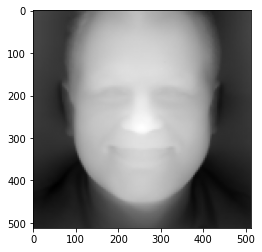

In [ ]:
resized_np['image']
plt.imshow(resized_np["image"])


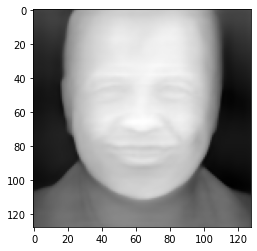

In [ ]:
downsample = Resize(width=128, height=128, resize_target=False)
double_res = downsample(resized_np)
plt.imshow(double_res["image"])

In [ ]:
#save 2 arrays as depth images
utils.write_depth('/content/gt_128', gt_np[:, :, 2], bits=1)
utils.write_depth('/content/gt_512', resized_np['image'][:, :, 2], bits=1)
utils.write_depth('/content/resized_128', double_res['image'][:, :, 2], bits=1)

In [ ]:
depthImage2mesh('/content/gt_128.png', save=True)

100%|██████████| 511/511 [00:19<00:00, 25.93it/s]


(tensor([[[0.0000, 0.0000, 0.4667],
          [0.0000, 0.0039, 0.4667],
          [0.0000, 0.0078, 0.4667],
          ...,
          [1.9961, 1.9883, 0.3490],
          [1.9961, 1.9922, 0.3569],
          [1.9961, 1.9961, 0.3725]]]), tensor([[[  1027,   1028,   1539],
          [  1540,   1539,   1028],
          [  1028,   1029,   1540],
          ...,
          [261630, 261631, 262142],
          [262143, 262142, 261631],
          [261631, 261632, 262143]]]), tensor([[[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000]]]))

In [ ]:
depthImage2mesh('/content/gt_512.png', save=True)

100%|██████████| 127/127 [00:01<00:00, 113.20it/s]


(tensor([[[0.0000, 0.0000, 0.4745],
          [0.0000, 0.0156, 0.4902],
          [0.0000, 0.0312, 0.4902],
          ...,
          [1.9844, 1.9531, 0.2784],
          [1.9844, 1.9688, 0.3020],
          [1.9844, 1.9844, 0.3412]]]), tensor([[[  259,   260,   387],
          [  388,   387,   260],
          [  260,   261,   388],
          ...,
          [16254, 16255, 16382],
          [16383, 16382, 16255],
          [16255, 16256, 16383]]]), tensor([[[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000]]]))

In [ ]:
depthImage2mesh('/content/resized_128.png', save=True)

100%|██████████| 127/127 [00:01<00:00, 112.45it/s]


(tensor([[[0.0000, 0.0000, 0.4353],
          [0.0000, 0.0156, 0.4353],
          [0.0000, 0.0312, 0.4431],
          ...,
          [1.9844, 1.9531, 0.7333],
          [1.9844, 1.9688, 0.7412],
          [1.9844, 1.9844, 0.7333]]]), tensor([[[  259,   260,   387],
          [  388,   387,   260],
          [  260,   261,   388],
          ...,
          [16254, 16255, 16382],
          [16383, 16382, 16255],
          [16255, 16256, 16383]]]), tensor([[[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000]]]))

In [ ]:
depthImage2mesh('/content/pred_128.png', save=True)

100%|██████████| 127/127 [00:01<00:00, 101.06it/s]


(tensor([[[ 0.0000,  0.0000,  0.3333],
          [ 0.0000,  0.0156,  0.4510],
          [ 0.0000,  0.0312,  0.5373],
          ...,
          [ 1.9844,  1.9531,  0.2706],
          [ 1.9844,  1.9688,  0.1529],
          [ 1.9844,  1.9844, -0.0431]]]), tensor([[[  259,   260,   387],
          [  388,   387,   260],
          [  260,   261,   388],
          ...,
          [16254, 16255, 16382],
          [16383, 16382, 16255],
          [16255, 16256, 16383]]]), tensor([[[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000]]]))

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_mesh('m2', vertices=verts, colors=colors, faces=faces)
writer.close()

In [ ]:
import os
import numpy as np
w = np.load(os.path.join(gt_data_path, 'seed0001.npy'))
print(w.shape)
print(w.dtype)
print(w[0])

(1, 14, 512)
float32
[[-0.05591475 -0.02665274  0.28139046 ... -0.11796942 -0.17887309
  -0.12235566]
 [-0.05591475 -0.02665274  0.28139046 ... -0.11796942 -0.17887309
  -0.12235566]
 [-0.05591475 -0.02665274  0.28139046 ... -0.11796942 -0.17887309
  -0.12235566]
 ...
 [-0.05591475 -0.02665274  0.28139046 ... -0.11796942 -0.17887309
  -0.12235566]
 [-0.05591475 -0.02665274  0.28139046 ... -0.11796942 -0.17887309
  -0.12235566]
 [-0.05591475 -0.02665274  0.28139046 ... -0.11796942 -0.17887309
  -0.12235566]]


In [ ]:
# Check val
val = np.load("/content/drive/MyDrive/eg3d/experiments/latent_train10k_samples/val.npy", allow_pickle=True)
val.item()['valX']

[['/content/drive/MyDrive/datasets/eg3d/images/seed0000.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0001.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0002.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0003.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0004.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0005.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0006.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0007.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0008.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0009.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0010.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0011.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0012.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0013.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0014.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0015

In [ ]:
# Add 2 latent codes
l200 = np.load('/content/drive/MyDrive/eg3d/experiments/latent_train10k_samples/seed0200/out.npy')
l14 = np.load('/content/drive/MyDrive/eg3d/experiments/latent_train10k_samples/seed0014/out.npy')

lnew = (l200+l14)/2
retarget_path = '/content/drive/MyDrive/eg3d/experiments/latent_train10k_samples/retargetting_seed0014and0200'
np.save(file=os.path.join(retarget_path, 'out.npy'), arr=lnew)